In [1]:
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
data = bmb.load_data("sleepstudy")

In [3]:
data.head()

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308


In [4]:
model = bmb.Model("Reaction ~ 1 + Days + (1 + Days | Subject)", data)
model

       Formula: Reaction ~ 1 + Days + (1 + Days | Subject)
        Family: gaussian
          Link: mu = identity
  Observations: 180
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 298.5079, sigma: 261.0092)
            Days ~ Normal(mu: 0.0, sigma: 48.8915)
        
        Group-level effects
            1|Subject ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 261.0092))
            Days|Subject ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 48.8915))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 56.1721)

In [5]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Reaction_sigma, Intercept, Days, 1|Subject_sigma, 1|Subject_offset, Days|Subject_sigma, Days|Subject_offset]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [6]:
df_new = data.head(10).reset_index(drop=True)
df_new["Subject"] = "xxx"
df_new = pd.concat([df_new, data.head(10)])
df_new = df_new.reset_index(drop=True)
df_new

,Reaction,Days,Subject
0,249.5600,0,xxx
1,258.7047,1,xxx
2,250.8006,2,xxx
3,321.4398,3,xxx
4,356.8519,4,xxx
5,414.6901,5,xxx
6,382.2038,6,xxx
7,290.1486,7,xxx
8,430.5853,8,xxx
9,466.3535,9,xxx


In [7]:
p = model.predict(idata, data=df_new, inplace=False, sample_new_groups=True)

reaction_draws = p.posterior["Reaction_mean"]
mean = reaction_draws.mean(("chain", "draw")).to_numpy()
bounds = reaction_draws.quantile((0.025, 0.975), ("chain", "draw")).to_numpy()

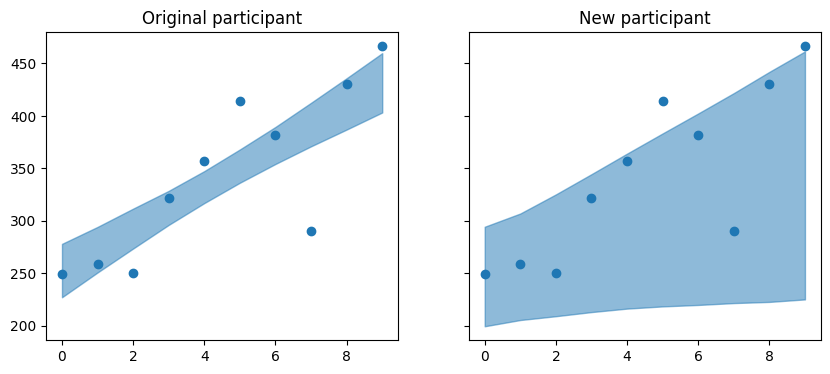

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

axes[0].scatter(df_new.iloc[10:]["Days"], df_new.iloc[10:]["Reaction"])
axes[1].scatter(df_new.iloc[:10]["Days"], df_new.iloc[:10]["Reaction"])

axes[0].fill_between(np.arange(10), bounds[0, 10:], bounds[1, 10:], alpha=0.5, color="C0")
axes[1].fill_between(np.arange(10), bounds[0, :10], bounds[1, :10], alpha=0.5, color="C0")

axes[0].set_title("Original participant")
axes[1].set_title("New participant");

---

In [9]:
data = pd.read_csv("tests/data/crossed_random.csv")
data.head()

,Unnamed: 0,subj,item,site,Y,continuous,dummy,threecats
0,0,0,0,0,0.276766,0.929616,0,a
1,1,1,0,0,-0.058104,0.008388,0,a
2,2,2,0,1,-6.847861,0.439645,0,a
3,3,3,0,1,12.474619,0.596366,0,a
4,4,4,0,2,-0.426047,0.709510,0,a


In [10]:
data["threecats"].unique()

array(['a', 'b', 'c'], dtype=object)

In [11]:
data["subj"].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [12]:
formula = "Y ~ 0 + threecats + (0 + threecats|subj)"
model = bmb.Model(formula, data)
model

       Formula: Y ~ 0 + threecats + (0 + threecats|subj)
        Family: gaussian
          Link: mu = identity
  Observations: 120
        Priors: 
    target = mu
        Common-level effects
            threecats ~ Normal(mu: [0. 0. 0.], sigma: [31.1617 31.1617 31.1617])
        
        Group-level effects
            threecats|subj ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: [31.1617 31.1617 31.1617]))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 5.8759)

In [13]:
idata = model.fit(tune=100, draws=100)

Only 100 samples in chain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Y_sigma, threecats, threecats|subj_sigma, threecats|subj_offset]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [14]:
new_data = pd.DataFrame(
    {
        "threecats": ["a", "b", "c"] * 2,
        "subj": list("xyz") * 2
    }
)
new_data

,threecats,subj
0,a,x
1,b,y
2,c,z
3,a,x
4,b,y
5,c,z


In [15]:
model.predict(idata, data=new_data, inplace=False, sample_new_groups=True)

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data